# CWT & STFT + CNN Model with BCI_competitionIII dataset

In [1]:
import mne
import numpy as np
from mne.datasets import eegbci
import matplotlib.pyplot as plt
from mne.channels import make_standard_montage

raw_each = [0] * 5

for i in range(0,5):
    raw_each[i] = mne.io.read_raw_edf("C:\git\Senior_Thesis\DataSet\Convert_data\hand"+ str(i) +"_new.edf",preload = True)

# raw_edf = mne.concatenate_raws(raw_each)
raw_edf = mne.concatenate_raws([raw_each[4]])
# raw_edf = raw_edf.copy().resample(62.5 ,npad="auto")

eegbci.standardize(raw_edf)  # set channel names
montage = make_standard_montage("standard_1005")
raw_edf.set_montage(montage)

Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand0_new.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 279249  =      0.000 ...  1116.996 secs...
Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand1_new.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 279249  =      0.000 ...  1116.996 secs...
Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand2_new.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 279249  =      0.000 ...  1116.996 secs...
Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand3_new.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 279249  =      0.000 ...  1116.996 secs...
Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand4_n

<RawEDF | hand4_new.edf, 8 x 279250 (1117.0 s), ~17.1 MB, data loaded>

In [2]:
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda, BatchNormalization, Activation
from keras.models import Sequential
from keras.callbacks import History,ModelCheckpoint
from keras.utils import plot_model
history = History()
import pywt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mne.decoding import CSP
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit,StratifiedKFold ,cross_val_score, cross_val_predict
from ssqueezepy import ssq_cwt, ssq_stft
import pickle

In [3]:
eeg1 = raw_edf.copy().filter(l_freq=4.0, h_freq=30.0, method = 'iir', iir_params= {"order": 5, "ftype":'butter'})
# eeg1 = raw_edf.copy().filter(l_freq=0.075, h_freq=3.0, method = 'fir')
eeg1 = eeg1.copy().set_eeg_reference(ref_channels="average")

eeg1= eeg1.pick(["Fz","C3", "Cz", "C4","Pz",'PO7','PO8'])
# eeg1= eeg1.pick_channels(["C3", "Cz", "C4"])
events, event_dict = mne.events_from_annotations(eeg1)
combine_epochs = mne.Epochs(eeg1, events, 
        tmin=-5.0,     # init timestamp of epoch (0 means trigger timestamp same as event start)
        tmax=5.0,    # final timestamp (10 means set epoch duration 10 second)
        event_id=event_dict,
        preload = True,
        event_repeated='drop'
    )

combine_epochs = combine_epochs.copy().crop(tmin=0.0, tmax=2.0)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 4.00, 30.00 Hz: -6.02, -6.02 dB



EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['OVTK_GDF_Cross_On_Screen', 'OVTK_GDF_End_Of_Session', 'OVTK_GDF_End_Of_Trial', 'OVTK_GDF_Feedback_Continuous', 'OVTK_GDF_Incorrect', 'OVTK_GDF_Left', 'OVTK_GDF_Right', 'OVTK_GDF_Start_Of_Trial', 'OVTK_GDF_Tongue', 'OVTK_GDF_Up', 'OVTK_StimulationId_BaselineStart', 'OVTK_StimulationId_BaselineStop', 'OVTK_StimulationId_Beep', 'OVTK_StimulationId_ExperimentStart', 'OVTK_StimulationId_Train']
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
612 matching events found
Setting baseline interval to [-5.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 612 events and 2501 original time points ...
2 bad epochs dropped


In [4]:
combine_epochs

Number of events,610
Events,OVTK_GDF_Cross_On_Screen: 7OVTK_GDF_End_Of_Session: 1OVTK_GDF_End_Of_Trial: 120OVTK_GDF_Feedback_Continuous: 120OVTK_GDF_Incorrect: 1OVTK_GDF_Left: 30OVTK_GDF_Right: 30OVTK_GDF_Start_Of_Trial: 120OVTK_GDF_Tongue: 30OVTK_GDF_Up: 30OVTK_StimulationId_BaselineStart: 1OVTK_StimulationId_Beep: 120OVTK_StimulationId_ExperimentStart: 0OVTK_StimulationId_Train: 0
Time range,0.000 – 2.000 s
Baseline,-5.000 – 0.000 s


In [5]:
combine_epochs['OVTK_GDF_Left','OVTK_GDF_Right','OVTK_GDF_Up','OVTK_GDF_Tongue'].events[:,2]

array([ 9, 10,  7,  6, 10, 10,  7,  7,  9, 10,  7,  6,  9, 10,  7,  6,  7,
       10,  6,  6,  6, 10,  9,  6,  9, 10,  7,  6,  9, 10,  9,  6,  9, 10,
        7,  7,  9, 10,  6, 10,  9, 10,  9,  9,  9, 10,  7,  6,  9, 10,  7,
        6,  9, 10,  7,  6,  9, 10,  7,  6,  9, 10,  9,  6,  9, 10,  6,  7,
       10, 10,  7,  6,  9,  7,  7,  6, 10, 10,  7,  6,  9, 10,  7,  6,  9,
       10,  7,  6,  6,  9,  7,  6,  9, 10,  7, 10,  9,  9,  7,  6,  9, 10,
        7,  6, 10,  6,  7,  6,  7,  9,  7,  6,  9, 10,  7,  6,  7,  9,  7,
        6])

In [6]:
# Prepare Labels and Train data
labels = combine_epochs['OVTK_GDF_Left','OVTK_GDF_Right','OVTK_GDF_Up','OVTK_GDF_Tongue'].events[:,2]
for i in range(0,len(labels)):
    if labels[i] > 7:
        labels[i] = labels[i] - 1
    # if labels[i] < 7:
    #     labels[i] = labels[i] + 1

shape = np.shape(combine_epochs['OVTK_GDF_Left','OVTK_GDF_Right','OVTK_GDF_Up','OVTK_GDF_Tongue'].get_data())
train_data = combine_epochs['OVTK_GDF_Left','OVTK_GDF_Right','OVTK_GDF_Up','OVTK_GDF_Tongue'].get_data()


In [7]:
labels

array([8, 9, 7, 6, 9, 9, 7, 7, 8, 9, 7, 6, 8, 9, 7, 6, 7, 9, 6, 6, 6, 9,
       8, 6, 8, 9, 7, 6, 8, 9, 8, 6, 8, 9, 7, 7, 8, 9, 6, 9, 8, 9, 8, 8,
       8, 9, 7, 6, 8, 9, 7, 6, 8, 9, 7, 6, 8, 9, 7, 6, 8, 9, 8, 6, 8, 9,
       6, 7, 9, 9, 7, 6, 8, 7, 7, 6, 9, 9, 7, 6, 8, 9, 7, 6, 8, 9, 7, 6,
       6, 8, 7, 6, 8, 9, 7, 9, 8, 8, 7, 6, 8, 9, 7, 6, 9, 6, 7, 6, 7, 8,
       7, 6, 8, 9, 7, 6, 7, 8, 7, 6])

Train with CSP+LDA

Computing rank from data with rank='full'
    MAG: rank 7 from info
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    MAG: rank 7 from info
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    MAG: rank 7 from info
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    MAG: rank 7 from info
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    MAG: rank 7 from info
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    MAG: rank 7 from info
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    MAG: rank 7 from info
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.

Done.
Computing rank from data with rank='full'
    MAG: rank 7 from info
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    MAG: rank 7 from info
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    MAG: rank 7 from info
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    MAG: rank 7 from info
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    MAG: rank 7 from info
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    MAG: rank 7 from info
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    MAG: rank 7 from info
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL

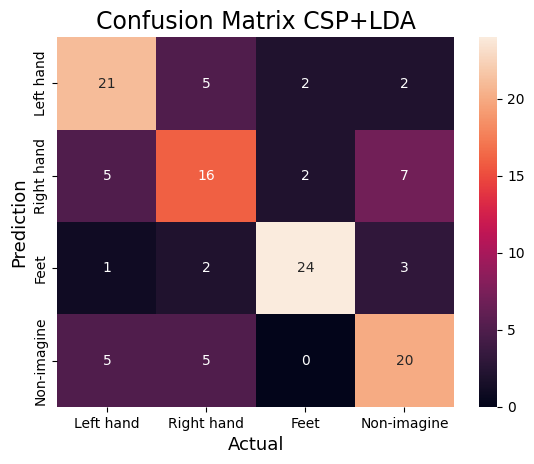

In [8]:
lda = LinearDiscriminantAnalysis()
from sklearn.metrics import confusion_matrix
csp2 = CSP(n_components=7, reg='empirical', log=True, norm_trace=True, rank='full')
clf = Pipeline([("CSP", csp2), ("LDA", lda)])
scores = cross_val_score(clf, train_data, labels, cv=10, n_jobs=None)
CSP_predicted = cross_val_predict(clf, train_data, labels, cv=10)

conf_matrix = confusion_matrix(labels, CSP_predicted)
print(conf_matrix)
print('Accuracy',np.mean(scores))

import seaborn as sns
class_names = ['Left hand', 'Right hand', 'Feet', 'Non-imagine']

sns.heatmap(conf_matrix, 
            annot=True,
            fmt='g', 
            xticklabels=class_names,
            yticklabels=class_names)
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix CSP+LDA',fontsize=17)
plt.show()

# CSP -> CWT -> CNN

train csp

In [9]:
# csp = CSP(n_components=7, reg=None, log=None, transform_into='csp_space')
# csp.fit(train_data, labels)
# new_data = csp.transform(train_data)

# with open('trained_csp_model.pkl', 'wb') as file:
#     pickle.dump(csp, file)


load csp

In [10]:
with open('trained_csp_model.pkl', 'rb') as file:
    trained_csp = pickle.load(file)

new_data = trained_csp.transform(train_data)

STFT

In [11]:
# from ssqueezepy import ssq_cwt, ssq_stft

# n_fft = 256  # Number of DFT points
# hop_length = int(n_fft * 0.03)  # 97% overlapping
# win_length = int(n_fft * 0.5)   # 0.5 seconds window length
# window = 'hamming' 
# train_size = len(labels)
# train_data_stft = np.ndarray(shape=(train_size, 129,143,7))


# _,coeff, *_ = ssq_stft(new_data[0,:], n_fft=n_fft, hop_len=hop_length, win_len=win_length, window=window)
# for i in range(0,train_size):
#     _,coeff, *_ = ssq_stft(new_data[0,:], n_fft=n_fft, hop_len=hop_length, win_len=win_length, window=window)
#     train_data_stft[i, :, :, :] = abs(coeff.reshape(coeff.shape[1],coeff.shape[2],coeff.shape[0]))

# np.shape(train_data_stft)

In [12]:
np.shape(new_data)

(120, 7, 501)

CWT

In [13]:
train_cwt = np.ndarray(shape=(new_data.shape[0], new_data.shape[2], 7))
for jj in range(0, new_data.shape[0]):
    train_cwt[jj] = new_data[jj].T
print(np.shape(new_data))

scales = range(4,31)

waveletname = 'morl'
train_size = len(labels)
train_data_cwt = np.ndarray(shape=(train_size, len(scales), new_data.shape[2], 7))

for ii in range(0,train_size):
    if ii % 40 == 0:
        print(ii)
    for jj in range(0,7):
        signal = train_cwt[ii, :, jj]
        coeff, _ = pywt.cwt(signal, scales, waveletname, 1)
        coeff_ = coeff[:,:new_data.shape[2]]  #crop 227 sample for each channel
        train_data_cwt[ii, :, :, jj] = coeff_
print(np.shape(train_data_cwt))

(120, 7, 501)
0
40
80
(120, 27, 501, 7)


In [14]:
# Stack array and convert to image
from PIL import Image as im 
train_cwt_stack = np.ndarray(shape=(train_size, len(scales)*7, new_data.shape[2]))

for jj in range(0,train_data_cwt.shape[0]):
    train_cwt_stack[jj] = np.vstack((train_data_cwt[jj,:,:,0], train_data_cwt[jj,:,:,1], train_data_cwt[jj,:,:,2], train_data_cwt[jj,:,:,3], train_data_cwt[jj,:,:,4], train_data_cwt[jj,:,:,5], train_data_cwt[jj,:,:,6]))
    # train_cwt_stack[jj] = im.fromarray(np.vstack((train_data_cwt[jj,:,:,0], train_data_cwt[jj,:,:,1], train_data_cwt[jj,:,:,2], train_data_cwt[jj,:,:,3], train_data_cwt[jj,:,:,4], train_data_cwt[jj,:,:,5], train_data_cwt[jj,:,:,6])), 'RGB')

print(np.shape(train_cwt_stack))

(120, 189, 501)


In [15]:
# from sklearn import preprocessing
# min_max_scaler = preprocessing.MinMaxScaler()
# for ii in range (0,train_size):
#     train_cwt_stack[ii] = min_max_scaler.fit_transform(train_cwt_stack[ii])

In [16]:
np.shape(train_cwt_stack)

(120, 189, 501)

In [17]:
labels

array([8, 9, 7, 6, 9, 9, 7, 7, 8, 9, 7, 6, 8, 9, 7, 6, 7, 9, 6, 6, 6, 9,
       8, 6, 8, 9, 7, 6, 8, 9, 8, 6, 8, 9, 7, 7, 8, 9, 6, 9, 8, 9, 8, 8,
       8, 9, 7, 6, 8, 9, 7, 6, 8, 9, 7, 6, 8, 9, 7, 6, 8, 9, 8, 6, 8, 9,
       6, 7, 9, 9, 7, 6, 8, 7, 7, 6, 9, 9, 7, 6, 8, 9, 7, 6, 8, 9, 7, 6,
       6, 8, 7, 6, 8, 9, 7, 9, 8, 8, 7, 6, 8, 9, 7, 6, 9, 6, 7, 6, 7, 8,
       7, 6, 8, 9, 7, 6, 7, 8, 7, 6])

In [18]:
x_train, x_test, y_train, y_test = train_test_split(train_cwt_stack, labels, test_size=0.3, random_state=42)

img_x = train_data_cwt.shape[1]
img_y = train_data_cwt.shape[2]
img_z = train_data_cwt.shape[3]
num_classes = 4

batch_size = 16
epochs = 30
print(np.shape(x_train), np.shape(x_test), np.shape(y_train), np.shape(y_test))

# plt.imshow(x_train[0,:,:,1], aspect='auto', cmap='turbo')
# plt.show()
y_train = keras.utils.to_categorical(y_train - 6, num_classes)
y_test = keras.utils.to_categorical(y_test -6 , num_classes)
input_shape = (img_x, img_y, img_z)

(84, 189, 501) (36, 189, 501) (84,) (36,)


# Purposed CNN Model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 187, 499, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 93, 249, 32)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 91, 247, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 123, 64)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 354240)            0         
                                                                 
 dense (Dense)               (None, 4)                 1

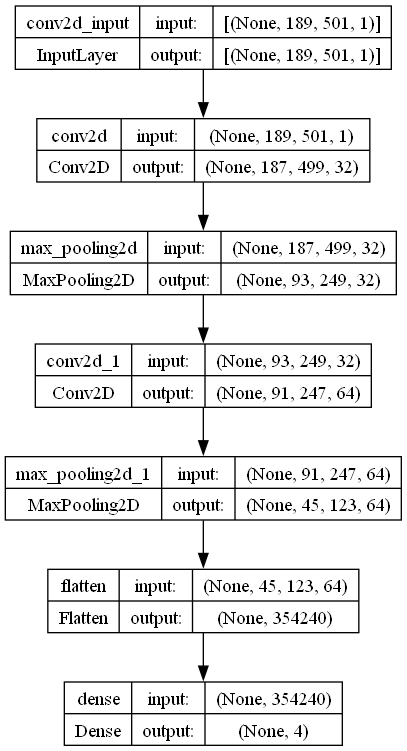

In [19]:
# Define the CNN model
model = Sequential()

# Convolutional Layer 1 with 32 filters of kernel size 3x3
model.add(Conv2D(32, (3, 3), input_shape=(train_cwt_stack.shape[1], train_cwt_stack.shape[2], 1), activation='relu'))

# Max-Pooling Layer 1 with pool size 2x2
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 2 with 64 filters of kernel size 3x3
model.add(Conv2D(64, (3, 3), activation='relu'))

# Max-Pooling Layer 2 with pool size 2x2
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output from the previous layer
model.add(Flatten())

# Output Layer with the desired number of output nodes (adjust as needed)
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Adam(learning_rate= 0.0001), 
              metrics=['accuracy'])

model.summary()
plot_model(model,to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# checkpoint = ModelCheckpoint("CNN_model_weights.h5", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# model.fit(x_train, y_train, batch_size=batch_size, 
#           epochs=epochs, verbose=1, 
#           validation_data=(x_test, y_test), 
#           callbacks=[history, checkpoint])


In [20]:
# fig, axarr = plt.subplots(figsize=(12,6), ncols=2)
# axarr[0].plot(range(1, epochs+1), history.history['accuracy'], label='Train')
# axarr[0].plot(range(1, epochs+1), history.history['val_accuracy'], label='Test')
# axarr[0].set_xlabel('Number of Epochs', fontsize=18)
# axarr[0].set_ylabel('Accuracy', fontsize=18)
# axarr[0].set_ylim([0,1.1])
# axarr[1].plot(range(1, epochs+1), history.history['loss'], label='Train')
# axarr[1].plot(range(1, epochs+1), history.history['val_loss'], label='Test')
# axarr[1].set_xlabel('Number of Epochs', fontsize=18)
# axarr[1].set_ylabel('Loss', fontsize=18)
# axarr[1].set_ylim([0,3.5])
# plt.legend()
# plt.show()

4/4 [==============================] - 1s 258ms/step


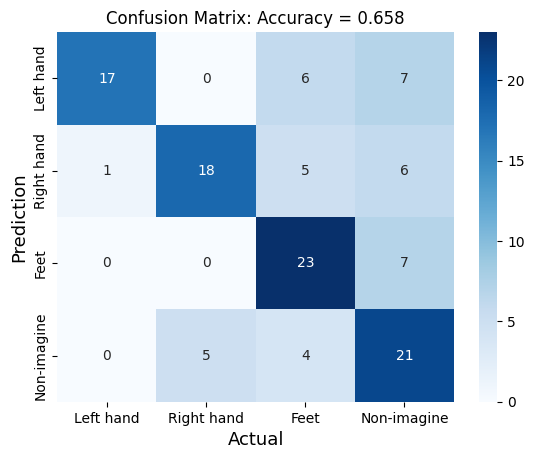

In [21]:
from keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns
pretrained_model = load_model("CNN_model_weights.h5")

y_test = keras.utils.to_categorical(labels -6 , num_classes)

loss, accuracy = pretrained_model.evaluate(train_cwt_stack, y_test)

y_pred = pretrained_model.predict(train_cwt_stack)
y_pred = np.argmax(y_pred, axis=1) 
y_true = np.argmax(y_test, axis=1)

confusion_mat = confusion_matrix(y_true, y_pred)

class_names = ['Left hand', 'Right hand', 'Feet', 'Non-imagine']

sns.heatmap(confusion_mat, 
            annot=True,
            fmt='d', 
            cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title("Confusion Matrix: Accuracy = "+ str(round(accuracy,3)))
plt.show()

# CNN Model (From Paper)

In [22]:
# # Define the CNN model
# model = Sequential()

# # Convolutional Layer with 16 filters of kernel size 3 and ReLU activation
# model.add(Conv2D(16, (3, 3), input_shape=input_shape))
# model.add(Activation('relu'))

# # Max-Pooling Layer with pool size 2x2 and stride 2
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# # Flatten the output from the previous layer
# model.add(Flatten())

# # Output Layer with 4 nodes
# model.add(Dense(num_classes, activation='softmax'))

# model.compile(loss=keras.losses.categorical_crossentropy, 
#               optimizer=keras.optimizers.Adam(learning_rate= 0.0001), 
#               metrics=['accuracy'])

# model.summary()

# checkpoint = ModelCheckpoint("3D_CNN_model_weights.h5", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# model.fit(x_train, y_train, batch_size=batch_size, 
#           epochs=epochs, verbose=1, 
#           validation_data=(x_test, y_test), 
#           callbacks=[history, checkpoint])


In [23]:
# fig, axarr = plt.subplots(figsize=(12,6), ncols=2)
# axarr[0].plot(range(1, 301), history.history['accuracy'], label='Train')
# axarr[0].plot(range(1, 301), history.history['val_accuracy'], label='Test')
# axarr[0].set_xlabel('Number of Epochs', fontsize=18)
# axarr[0].set_ylabel('Accuracy', fontsize=18)
# axarr[0].set_ylim([0,1.1])
# axarr[1].plot(range(1, 301), history.history['loss'], label='Train')
# axarr[1].plot(range(1, 301), history.history['val_loss'], label='Test')
# axarr[1].set_xlabel('Number of Epochs', fontsize=18)
# axarr[1].set_ylabel('Loss', fontsize=18)
# axarr[1].set_ylim([0,1.1])
# plt.legend()
# plt.show()